# Trabalho ENGA75

### Autor: Allan Almeida

In [1]:
from ur5 import UR5, forward_kinematics
from math import pi
import numpy as np
import matplotlib.pyplot as plt
ur5 = UR5()
PI = pi

Inicializando a classe UR5...
Inicializando os nós e handles...
Pronto!


In [ ]:
ur5.get_joint_angles()

In [3]:
ur5.setup_camera()

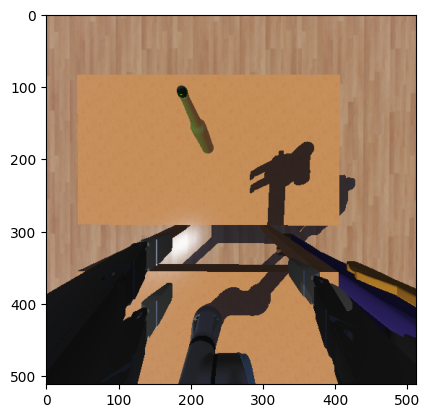

In [4]:
original_img = ur5.get_image()
plt.imshow(original_img)
plt.show()

(512, 512)


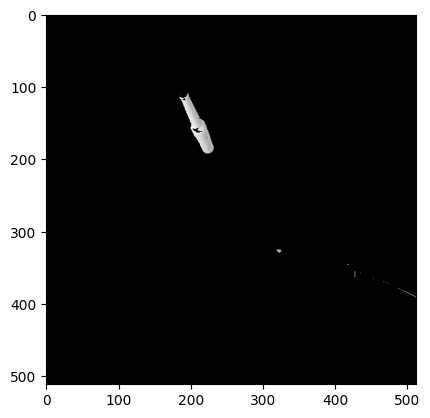

Centroid X: 255.69811313518696
Centroid Y: 255.99446212847556


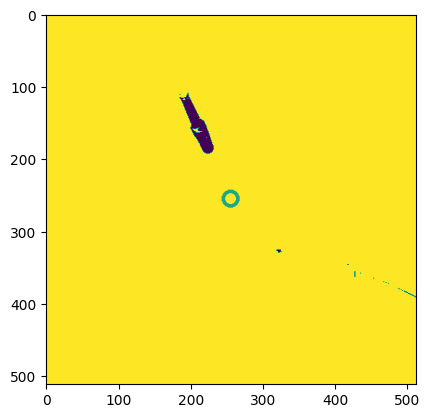

In [30]:
import cv2
from skimage import measure
bgr_image = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
# Define the lower and upper bounds for the green color range
lower_green = np.array([0, 60, 0], dtype=np.uint8)
upper_green = np.array([50, 255, 100], dtype=np.uint8)
mask = cv2.inRange(bgr_image, lower_green, upper_green)
green_image = cv2.bitwise_and(bgr_image, bgr_image, mask=mask)
green_image = cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB)
final_img = cv2.cvtColor(green_image, cv2.COLOR_RGB2GRAY)
print(final_img.shape)
plt.imshow(final_img, cmap='gray')
plt.show()
# Apply thresholding to segment the bottle from the background
_, thresholded = cv2.threshold(final_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Threshold the image to convert it to binary (0 or 1)
binary_image = thresholded > 0

# Label connected components in the binary image
labels = measure.label(binary_image)

# Find the label corresponding to the largest connected component (assuming it's the bottle)
largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

# Create a mask for the largest connected component
largest_component_mask = labels == largest_label

# Apply the mask to the original grayscale image to extract the bottle
bottle_image = thresholded.copy()
bottle_image[~largest_component_mask] = 0

# Find the centroid of the largest connected component (bottle)
props = measure.regionprops(largest_component_mask.astype(np.uint8))
centroid = props[0].centroid

# Print the centroid coordinates
print("Centroid X:", centroid[1])
print("Centroid Y:", centroid[0])
plt.imshow(cv2.circle(thresholded, (int(centroid[1]), int(centroid[0])), 10, (150, 0, 0), 3))

## Etapa A1

Implementar a Cinemática Direta e Inversa do Robô UR5. Validar a modelagem com o auxílio do
simulador para um conjunto de valores das variáveis das juntas (Cinemática Direta) e para um conjunto de
posições e orientações da garra (Cinemática Inversa)

#### Cinemática Direta

<img src="Cinemática Direta (DH).png" width="500">

In [ ]:
def validate_fk(ang):
    fk, _ = forward_kinematics(ang)    # Calcular cinemática direta a partir dos ângulos
    print('Cinemática Direta: ')
    print(fk)
    ur5.move_to_config(ang)     # Mover para a posição
    print('Ground Truth: ')
    gt = ur5.get_ground_truth()     # Obter Ground Truth
    print(gt)
    print('Erro: ', np.linalg.norm(fk-gt)/np.linalg.norm(gt)*100, '%')  # Calcular e printar erro

In [ ]:
validate_fk([.5*PI, .05*PI, .45*PI, 0, -.5*PI, .5*PI])

In [ ]:
validate_fk([-.5*PI, -.05*PI, -.45*PI, 0, .5*PI, .5*PI])

In [ ]:
validate_fk([PI/2, 0, 0, 0, 0, 0])

In [ ]:
validate_fk([.1*PI, .18*PI, .57*PI, 0.25*PI, 0.2, PI/2])

In [ ]:
validate_fk([-.3*PI, -.04*PI, -.8*PI, -0.17*PI, -0.5, PI/2])

In [ ]:
validate_fk([0.2, .04*PI, .8*PI, 0.17*PI, 0.3, PI/2])

#### Cinemática Inversa

<img src="gripper.jpg" width="700">

In [ ]:
ur5.move_to_pose([-0.1, -.55, .4], [PI, 0, PI/2], wrist='up')

In [ ]:
ur5.move_to_pose([-0.1, -.55, .4], [0, 0, -PI/2], wrist='down')

In [ ]:
ur5.move_to_pose([-0.1, -.55, .4], [PI/2, 0, -PI/2], wrist='down')

In [ ]:
ur5.move_to_pose([-0.1, -.45, .4], [PI/2, 0, -PI/2], wrist='down')

In [ ]:
ur5.move_to_pose([-0.1, -.45, .25], [PI/2, 0, -PI/2], wrist='down')

## Etapa A2

Implementar um sistema de planejamento de trajetórias no espaço de juntas com uma das abordagens
abaixo:

1. Trajetórias polinomiais cúbicas ou de quinto grau;
2. Linear Segments with Parabolic Blends (LSPB);
3. Minimum Time Trajectories

<b>Polinômio de Quinto Grau</b>

$q(t) = a_0+a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$

$\dot{q}(t) = a_1 + 2 a_2 t + 3 a_3 t^2 + 4 a_4 t^3 + 5 a_5 t^4$

$\ddot{q}(t) = 2 a_2 + 6 a_3 t + 12 a_4 t^2 + 20 a_5 t^3$

$\begin{bmatrix}
1 & t_0 & t_0^2 & t_0^3 & t_0^4 & t_0^5\\
0 & 1 & 2t_0 & 3t_0^2 & 4t_0^3 & 5t_0^4\\
0 & 0 & 2 & 6t_0 & 12t_0^2 & 20t_0^3\\
1 & t_f & t_f^2 & t_f^3 & t_f^4 & t_f^5\\
0 & 1 & 2t_f & 3t_f^2 & 4t_f^3 & 5t_f^4\\
0 & 0 & 2 & 6t_f & 12t_f^2 & 20t_f^3\\
\end{bmatrix} \cdot \begin{bmatrix}
a_0\\
a_1\\
a_2\\
a_3\\
a_4\\
a_5\\
\end{bmatrix} = \begin{bmatrix}
q_0\\
\dot{q}_0\\
\ddot{q}_0\\
q_f\\
\dot{q}_f\\
\ddot{q}_f\\
\end{bmatrix}$


$A\cdot X = B$

In [ ]:
t, max_err, mean_err, graphs, _ = ur5.move_to_config([.5*PI, .05*PI, .45*PI, 0, .5*PI, .3*PI], graph=True)

In [ ]:
titles = ['Posição', 'Velocidade', 'Aceleração', 'Solavanco']
axes = ['rad', 'rad/s', 'rad/$s^2$', 'rad/$s^3$']

for i in range(4):
    for j in range(6):
        plt.plot(graphs[4][j], graphs[i][j])
    plt.legend(['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    plt.grid()
    plt.title(titles[i], fontsize=18)
    plt.ylabel(axes[i], rotation=0, labelpad=20)
    plt.xlabel('t [s]')
    plt.show()

## Jacobiano

In [ ]:
_, _, _, _, _ = ur5.move_to_config([0, 0, 0, 0, 0, 0])

In [ ]:
_, _, _, graphs, jacob = ur5.move_to_config([0, -PI/2, 0, 0, 0, 0], graph=True, jacob=True, duration=None)

In [ ]:
for j in range(6):
    plt.plot(graphs[4][j], graphs[1][j])
plt.legend(['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
plt.grid()
plt.title('Velocidade', fontsize=18)
plt.ylabel('rad/s', rotation=0, labelpad=20)
plt.xlabel('t [s]')
plt.show()

In [ ]:
for j in range(3):
    plt.plot(graphs[4][j], [i[j] for i in jacob])
plt.title('Jacobiano (vel. lin.)', fontsize=18)
plt.legend(['$v_x$', '$v_y$', '$v_z$'])
plt.xlabel('t [s]')
plt.ylabel('m/s', rotation=0, labelpad=20)
plt.show()

for j in range(3, 6):
    plt.plot(graphs[4][j], [i[j] for i in jacob])
plt.title('Jacobiano (vel,. ang.)', fontsize=18)
plt.legend(['$\omega_x$', '$\omega_y$', '$\omega_z$'])
plt.xlabel('t [s]')
plt.ylabel('rad/s', rotation=0, labelpad=20)
plt.show()

## Visão Computacional | Pick and Place

### Pose de Leitura

In [2]:
ur5.move_to_pose([-0.1, -.7, .45], [PI, 0, -PI/2], wrist='up')

Iterações totais:  140
Erro pose final:  1.1800447281824797 %


In [3]:
bottle_position = ur5.get_bottle_frame()[:3, 3]

### Pre-graspping

In [4]:
ur5.move_to_pose([bottle_position[0]+.03, bottle_position[1]+.3, bottle_position[2]+.1], [PI/2, 0, -PI/2], wrist='down')

Iterações totais:  249
Erro pose final:  2.0307203902985185 %


### Graspping

In [5]:
ur5.move_to_pose([bottle_position[0]+.03, bottle_position[1]+.02, bottle_position[2]+.1], [PI/2, 0, -PI/2], wrist='down', duration=6)

Iterações totais:  188
Erro pose final:  1.68963489816196 %


In [6]:
ur5.actuate_gripper(1)

Iterações totais:  63
2.016000000000002


### Moving

In [7]:
ur5.move_to_pose([-.7, 0, .6], [PI/2, -1.5708+.3, -PI/2], wrist='up')

Iterações totais:  250
Erro pose final:  0.8628005846781577 %


In [8]:
ur5.move_to_pose([-.64, 0.06, .6], [0, .9, 0], wrist='down')

Iterações totais:  270
Erro pose final:  1.1766392703345399 %


In [9]:
ur5.move_to_pose([-.7, 0.06, .74], [0, .0, 0], wrist='down')

Iterações totais:  70
Erro pose final:  1.1352294233910059 %


### Pre-placing

In [10]:
ur5.move_to_pose([-.4, .1, .5], [-PI/2, 0, PI/2], wrist='up')

Iterações totais:  256
Erro pose final:  3.241325429438617 %


### Placing

In [11]:
ur5.move_to_pose([-.4, .1, .15], [-PI/2, 0, PI/2], wrist='up', duration=6)

Iterações totais:  188
Erro pose final:  3.301437121700358 %


In [12]:
ur5.actuate_gripper(0)

Iterações totais:  63
2.0160000000000053


In [13]:
ur5.move_to_pose([-.4, -.1, .15], [-PI/2, 0, PI/2], wrist='up')

Iterações totais:  47
Erro pose final:  2.782774979083931 %


### Retorna pose de leitura

In [14]:
ur5.move_to_pose([-0.1, -.55, .4], [PI, 0, -PI/2], wrist='up')

Iterações totais:  249
Erro pose final:  1.230761241520973 %
